In [1]:
%load_ext autoreload
%autoreload 2

# Classification

We train a model for the task of multilabel classification.

In [72]:
from src.dm import ClassificationDataModule

dm = ClassificationDataModule()

dm.setup()

Training on 74 images
Validating on 18 images


In [73]:
batch = next(iter(dm.train_dataloader()))

batch[0].shape, batch[1]

(torch.Size([16, 3, 384, 384]),
 tensor([[0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0.]]))

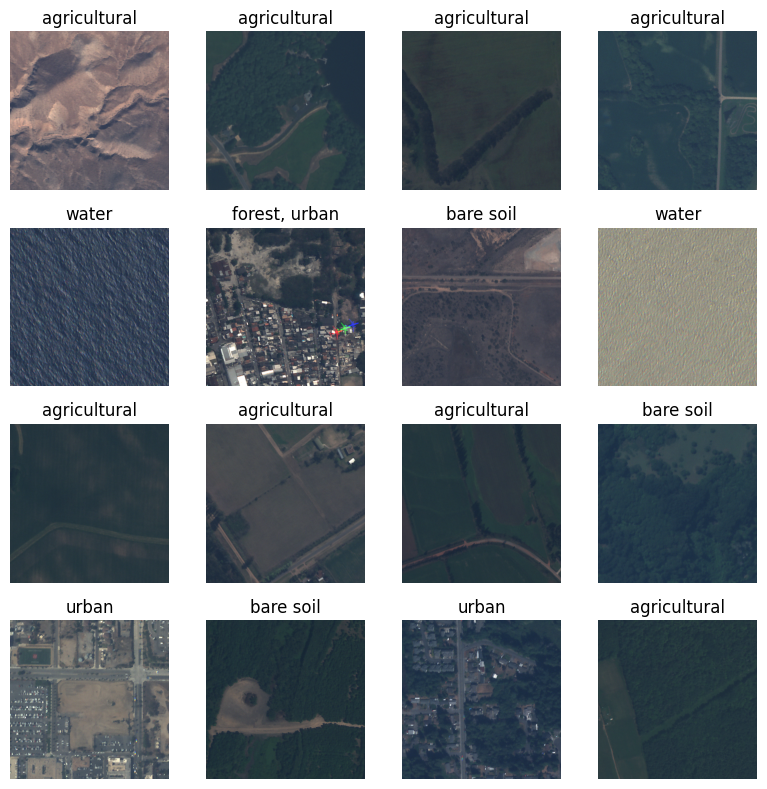

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()
images, labels = next(iter(dm.train_dataloader()))
for i in range(16):
    img = images[i].numpy().transpose(1,2,0)
    axes[i].imshow(img)
    class_indices = np.where(labels[i].numpy() == 1)[0]
    class_names = [dm.classes[idx] for idx in class_indices]
    axes[i].set_title(', '.join(class_names))
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from src.module import ClassificationModule

module = ClassificationModule()

outputs = module(images)
outputs.shape

torch.Size([16, 6])

In [33]:
import lightning as L

dm = ClassificationDataModule(batch_size=4, num_workers=0, pin_memory=False)
module = ClassificationModule()

trainer = L.Trainer(
    max_epochs=20,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=[1],
    logger=None,
    enable_checkpointing=False,
    overfit_batches=4,
)

trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ClassificationModel | 11.2 M | train
1 | loss      | BCEWithLogitsLoss   | 0      | train
2 | train_acc | MultilabelAccuracy  | 0      | train
3 | val_acc   | MultilabelAccuracy  | 0      | train
----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.718    Total estimated model params size (MB)
98        Modules in train mode
0         Modules in eval mode


Training on 74 images
Validating on 18 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:252: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [34]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint


dm = ClassificationDataModule(batch_size=16, num_workers=4, pin_memory=True)
module = ClassificationModule()

trainer = L.Trainer(
    max_epochs=30,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=[1],
    logger=CSVLogger('logs', name='classification'),
    callbacks=[ModelCheckpoint(
        monitor='val_acc', mode='max', save_top_k=1, save_last=True,
        dirpath='checkpoints', filename='classification-{epoch}-{val_acc:.2f}'
    )],
    log_every_n_steps=2,
)

trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ClassificationModel | 11.2 M | train
1 | loss      | BCEWithLogitsLoss   | 0      | train
2 | train_acc | MultilabelAccuracy  | 0      | train
3 | val_acc   | MultilabelAccuracy  | 0      | train
----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.718    Total estimated model params size (MB)
98        Modules in train mode
0         Modules in eval mode


Training on 74 images
Validating on 18 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


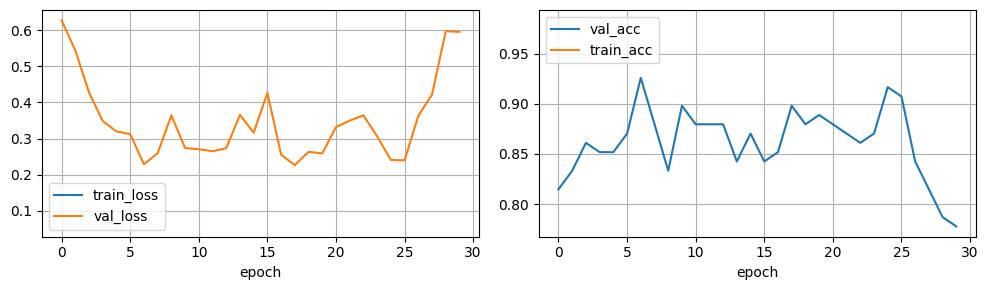

In [35]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/classification'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/classification/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_acc', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_acc', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()

We can export the model to ONNX and ingest to EOTDL.

In [47]:
module = ClassificationModule.load_from_checkpoint('checkpoints/classification-epoch=6-val_acc=0.93.ckpt')

In [48]:
import torch

export_model = torch.nn.Sequential(
    module,
    torch.nn.Sigmoid()
)
export_model.eval()
export_model.to('cpu');

In [49]:
torch.onnx.export(
	export_model,
	images,
	'outputs/classification.onnx',
	export_params=True,
	input_names=['input'],
	output_names=['output'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'output': {
			0: 'batch_size'
		}
	}
)

In [50]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession('outputs/classification.onnx')
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: images.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(2, 6)

In [51]:
from torchmetrics.classification import MultilabelAccuracy

metric = MultilabelAccuracy(num_labels=6)

for batch in dm.val_dataloader():
    images, labels = batch
    ort_inputs = {input_name: images.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    preds = ort_outs[0]
    metric(torch.from_numpy(preds), labels)

metric.compute()

tensor(0.9259)

In [52]:
# create README.md

text = """---
name: UseCaseCModels
authors: 
  - Juan B. Pedro
license: free
source: https://github.com/earthpulse/eotdl/blob/main/tutorials/usecases/useCaseC/trianing.ipynb
---

# UseCaseCModels

Models developed for the use case C.
"""

with open(f"outputs/README.md", "w") as outfile:
    outfile.write(text)

Uncomment to ingest, we will train now more models later so ingesting at the end.

In [53]:
# !eotdl models ingest -p outputs

# Segmentation

We train now a model with the segmentation labels.

In [2]:
from src.dm import SegmentationDataModule

dm = SegmentationDataModule()

dm.setup()

Training on 80 images
Validating on 20 images


In [3]:
batch = next(iter(dm.train_dataloader()))

images, masks = batch

images.shape, masks.shape

(torch.Size([16, 3, 384, 384]), torch.Size([16, 16, 384, 384]))

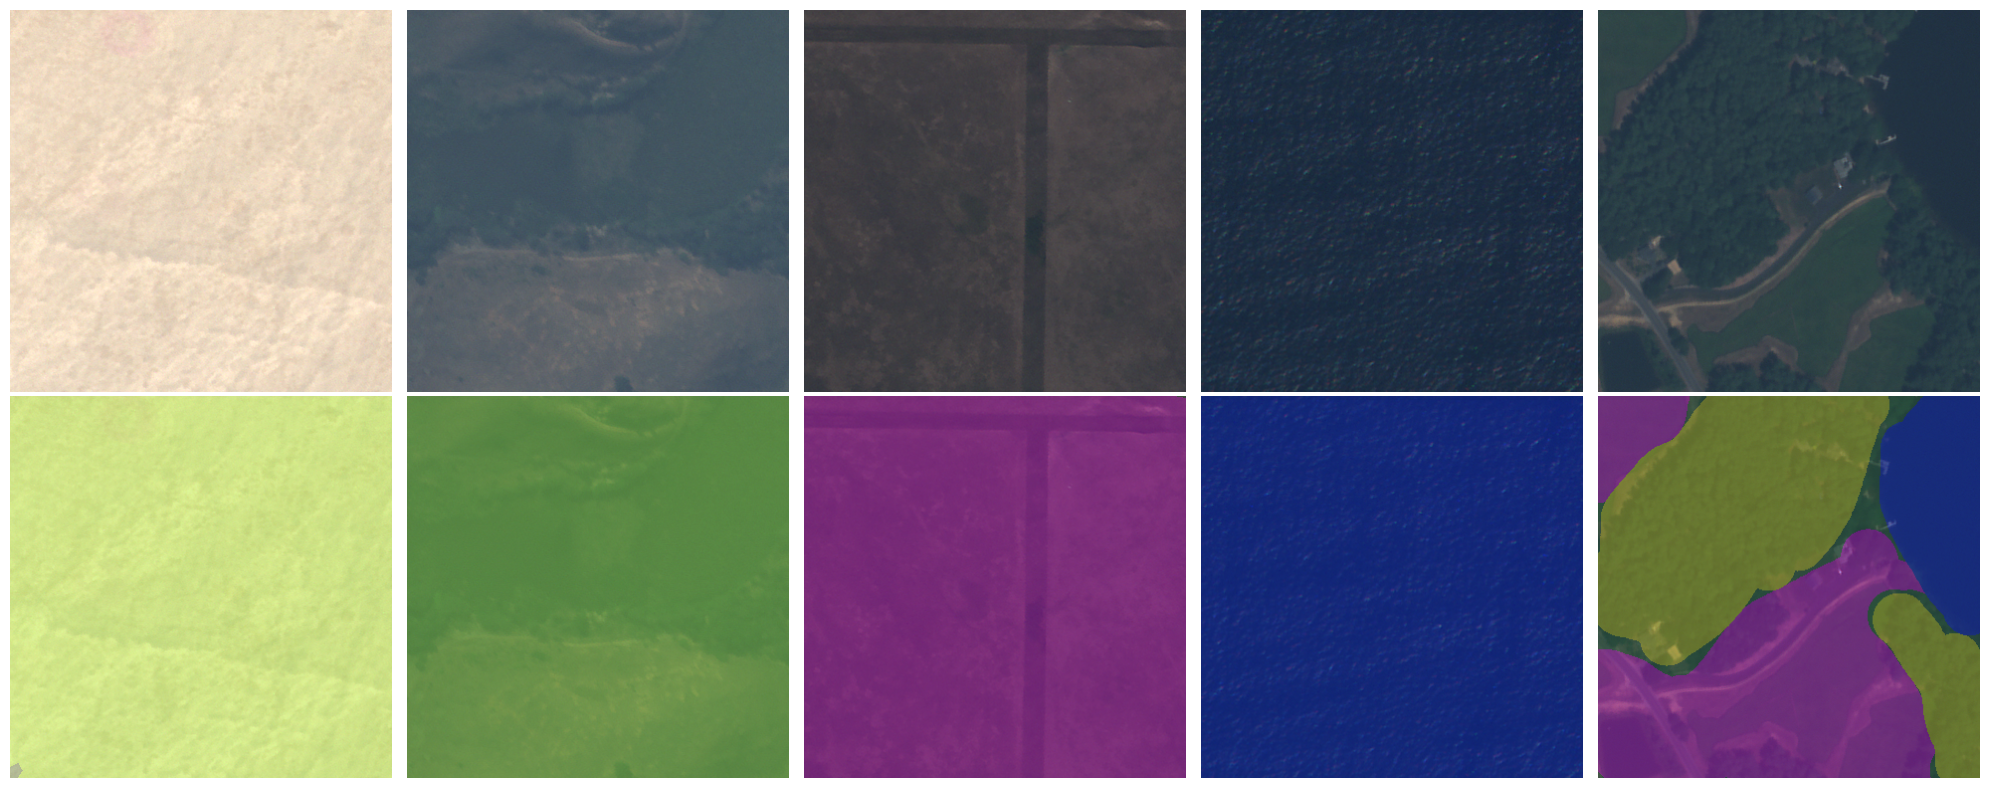

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
_colors = ['#000000'] + [ dm.colors.get(l) for l in list(dm.colors.keys()) ]
cmap = ListedColormap(_colors)

batch = next(iter(dm.train_dataloader()))
images, masks = batch
for i in range(5):
    axes[0, i].imshow(images[i].permute(1,2,0))
    axes[0, i].axis('off')    
    axes[1, i].imshow(images[i].permute(1,2,0))
    axes[1, i].imshow(masks[i].argmax(0) + 1, cmap=cmap, vmin=0, vmax=len(dm.colors)+1, alpha=0.3)
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


In [5]:
from src.module import SegmentationModule

module = SegmentationModule()

outputs = module(images)

outputs.shape

torch.Size([16, 6, 384, 384])

In [6]:
import lightning as L

dm = SegmentationDataModule(batch_size=4, num_workers=0, pin_memory=False)
module = SegmentationModule(num_classes=dm.num_classes)

trainer = L.Trainer(
    max_epochs=80,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=[1],
    logger=None,
    enable_checkpointing=False,
    overfit_batches=1,
)

# trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


In [7]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint


dm = SegmentationDataModule(batch_size=16, num_workers=4, pin_memory=True)
module = SegmentationModule(num_classes=dm.num_classes)

trainer = L.Trainer(
    max_epochs=100,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=[1],
    logger=CSVLogger('logs', name='segmentation'),
    callbacks=[ModelCheckpoint(
        monitor='val_iou', mode='max', save_top_k=1, save_last=True,
        dirpath='checkpoints', filename='segmentation-{epoch}-{val_iou:.2f}'
    )],
    log_every_n_steps=2,
)

trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/juan/Desktop/eotdl/tutorials/usecases/useCaseC/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | SegmentationModel | 14.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------

Training on 80 images
Validating on 20 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


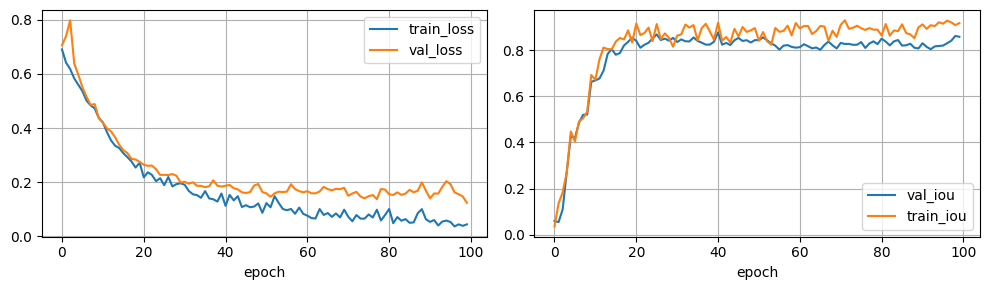

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/segmentation'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/segmentation/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_iou', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_iou', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()

We can export to ONNX and ingest to EOTDL.

In [9]:
module = SegmentationModule.load_from_checkpoint('checkpoints/segmentation-epoch=40-val_iou=0.88.ckpt')


In [10]:
import torch

export_model = torch.nn.Sequential(
    module,
    # torch.nn.Sigmoid()
)
export_model.eval()
export_model.to('cpu');

In [11]:
torch.onnx.export(
	export_model,
	images,
	'outputs/segmentation.onnx',
	export_params=True,
	input_names=['input'],
	output_names=['output'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'output': {
			0: 'batch_size'
		}
	}
)

In [12]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession('outputs/segmentation.onnx')
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: images.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(16, 16, 384, 384)

In [13]:
from src.module import iou

metrics = []
for batch in dm.val_dataloader():
    images, labels = batch
    ort_inputs = {input_name: images.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    preds = ort_outs[0]
    metrics.append(iou(torch.from_numpy(preds), labels))

np.mean(metrics)

0.8634194

In [ ]:
# !eotdl models ingest -p outputs

# Detection

> TODO

# Multitask Learning

We now train one model for all tasks.

In [86]:
from src.dm import MultiTaskDataModule

dm = MultiTaskDataModule()

dm.setup()

Training on 74 images
Validating on 18 images


In [88]:
batch = next(iter(dm.train_dataloader()))

images, masks, labels = batch

images.shape, masks.shape, labels.shape

(torch.Size([16, 3, 384, 384]),
 torch.Size([16, 16, 384, 384]),
 torch.Size([16, 6]))

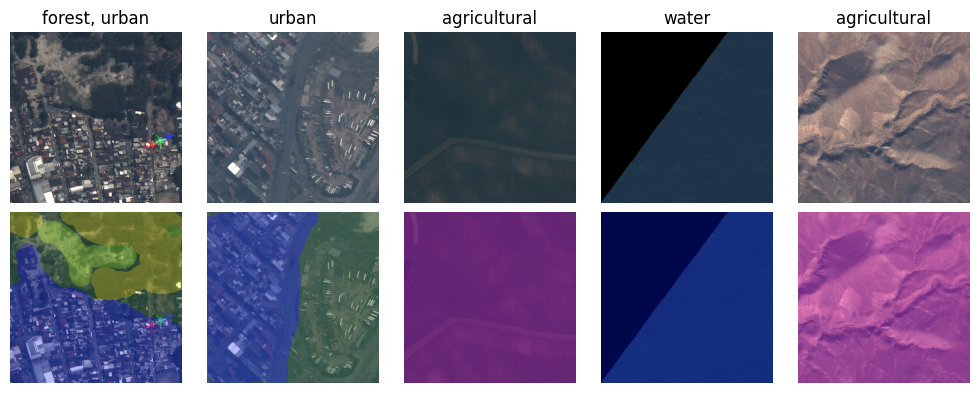

In [78]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
_colors = ['#000000'] + [ dm.colors.get(l) for l in list(dm.colors.keys()) ]
cmap = ListedColormap(_colors)

batch = next(iter(dm.train_dataloader()))
images, masks, labels = batch
for i in range(5):
    axes[0, i].imshow(images[i].permute(1,2,0))
    axes[0, i].axis('off')    
    class_indices = np.where(labels[i].numpy() == 1)[0]
    class_names = [dm.classification_classes[idx] for idx in class_indices]
    axes[0, i].set_title(', '.join(class_names))
    axes[1, i].imshow(images[i].permute(1,2,0))
    axes[1, i].imshow(masks[i].argmax(0) + 1, cmap=cmap, vmin=0, vmax=len(dm.colors)+1, alpha=0.3)
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


In [90]:
from src.module import MultiTaskModule

module = MultiTaskModule()

seg_preds, cls_preds = module(images)

seg_preds.shape, cls_preds.shape

(torch.Size([16, 6, 384, 384]), torch.Size([16, 6]))

In [92]:
import lightning as L

dm = MultiTaskDataModule(batch_size=4, num_workers=0, pin_memory=False)
module = MultiTaskModule(num_seg_classes=dm.num_seg_classes, num_cls_classes=dm.num_cls_classes)

trainer = L.Trainer(
    max_epochs=80,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=[1],
    logger=None,
    enable_checkpointing=False,
    overfit_batches=4,
)

# trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | MultiTaskModel     | 14.3 M | train
1 | seg_loss      | BCEWithLogitsLoss  | 0      | train
2 | cls_loss      | BCEWithLogitsLoss  | 0      | train
3 | train_cls_acc | MultilabelAccuracy | 0      | train
4 | val_cls_acc   | MultilabelAccuracy | 0      | train
-------------------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.392    Total estimated model params size (MB)
151       Modules in train mode
0         Modules in eval mode


Training on 74 images
Validating on 18 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:252: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [93]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint


dm = MultiTaskDataModule(batch_size=16, num_workers=10, pin_memory=True)
module = MultiTaskModule(num_seg_classes=dm.num_seg_classes, num_cls_classes=dm.num_cls_classes)

trainer = L.Trainer(
    max_epochs=100,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=[1],
    logger=CSVLogger('logs', name='multitask'),
    callbacks=[
        ModelCheckpoint(    
            monitor='val_acc', mode='max', save_top_k=1, save_last=True,
            dirpath='checkpoints', filename='multitask-{epoch}-{val_acc:.2f}'
        ), 
        ModelCheckpoint(
            monitor='val_iou', mode='max', save_top_k=1, save_last=True,
            dirpath='checkpoints', filename='multitask-{epoch}-{val_iou:.2f}'
        )
    ],
    log_every_n_steps=2,
)

trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/juan/Desktop/eotdl/tutorials/usecases/useCaseC/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | MultiTaskModel     | 14.3 M | train
1 | seg_loss      | BCEWithLogitsLoss  | 0      | train
2 | cls_loss      | BCEWithLogitsLoss  | 0      | train
3 | train_cls_acc | MultilabelAccuracy | 0      | train
4 | val_cls_acc   | MultilabelAccuracy | 0      | train
-------------------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.392    Total estimated m

Training on 74 images
Validating on 18 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


KeyError: 'val_acc'

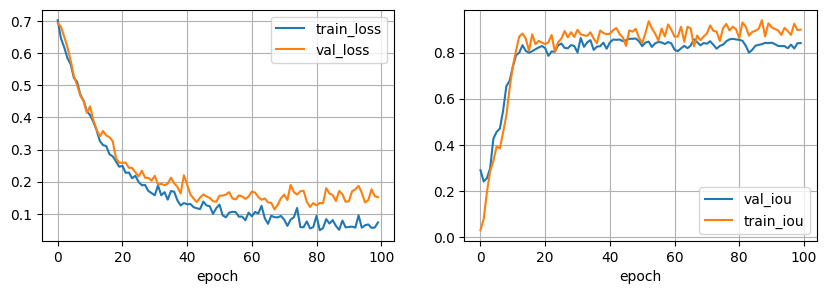

In [94]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/segmentation'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/segmentation/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_iou', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_iou', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='val_acc', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_acc', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()

In [95]:
metrics

epoch  step  train_iou  train_loss   val_iou  val_loss
0       0     4   0.029876    0.702398  0.290127  0.693598
1       1     9   0.078939    0.645466  0.241156  0.681870
2       2    14   0.195084    0.618283  0.255562  0.651322
3       3    19   0.286265    0.584376  0.298880  0.617680
4       4    24   0.330661    0.565317  0.427066  0.576457
..    ...   ...        ...         ...       ...       ...
95     95   479   0.893074    0.064456  0.818652  0.135337
96     96   484   0.876759    0.067046  0.834435  0.142442
97     97   489   0.925127    0.056404  0.817632  0.176284
98     98   494   0.897519    0.057363  0.840341  0.154783
99     99   499   0.899484    0.073117  0.841168  0.151733

[100 rows x 6 columns]

We can export the model to ONNX format and ingest to EOTDL

In [98]:
module = MultiTaskModule.load_from_checkpoint('checkpoints/epoch=66-val_acc=0.94.ckpt')


In [99]:
import torch

export_model = torch.nn.Sequential(
    module,
    # torch.nn.Sigmoid()
)
export_model.eval()
export_model.to('cpu');

In [101]:
torch.onnx.export(
	export_model,
	images,
	'outputs/multitask.onnx',
	export_params=True,
	input_names=['input'],
	output_names=['seg_preds', 'cls_preds'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'seg_preds': {
			0: 'batch_size'
		},
		'cls_preds': {
			0: 'batch_size'
		}
	}
)

In [102]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession('outputs/multitask.onnx')
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: images.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape, ort_outs[1].shape

((16, 16, 384, 384), (16, 6))

In [103]:
from src.module import iou
from torchmetrics.classification import MultilabelAccuracy

metrics = []
metric = MultilabelAccuracy(num_labels=6)

for batch in dm.val_dataloader():
    images, masks, labels = batch
    ort_inputs = {input_name: images.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    preds_seg, preds_cls = ort_outs
    metrics.append(iou(torch.from_numpy(preds_seg), masks))
    metric(torch.from_numpy(preds_cls), labels)

np.mean(metrics), metric.compute()

(0.80716455, tensor(0.9352))